### setup

In [1]:
import os
import argparse
import pickle
import time

import numpy as np; np.seterr(invalid='ignore')
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import TensorDataset, DataLoader

In [2]:
parser = {
    'data_path': '../data/wttsf/',
    'train_file': 'train_1.csv',
    'key_file': 'key_1.csv',
    'intermediate_path': '../intermediate/',
    'n_epoch': 4,
    'future': 70,
    'batch_size': 128,
    'hidden_size': 256,
    'log_every': 10,
    'read_from_file': True,
    'cuda': True,
    'seed': 28082017,
}
args = argparse.Namespace(**parser)

args.cuda = args.cuda and torch.cuda.is_available()
torch.manual_seed(args.seed);

### model

In [3]:
class DenseLSTMForecast(nn.Module):
    def __init__(self, hidden_size):
        super(DenseLSTMForecast, self).__init__()
        self.lstm1 = nn.LSTMCell(1, hidden_size, bias=False)
        self.lstm2 = nn.LSTMCell(hidden_size+1, hidden_size, bias=False)
        self.linear = nn.Linear(2*hidden_size+1, 1, bias=False)
        self.hidden_size = hidden_size

    def forward(self, x, future=1):
        o = []
        tt = torch.cuda if args.cuda else torch
        h1_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        c1_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        h2_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        c2_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        
        for x_t in x.chunk(x.size(1), dim=1):
            x_t = x_t.squeeze(dim=1)
            h1_t, c1_t = self.lstm1(x_t, (h1_t, c1_t))
            h1d_t = torch.cat([x_t, h1_t], dim=1)
            h2_t, c2_t = self.lstm2(h1d_t, (h2_t, c2_t))
            h2d_t = torch.cat([x_t, h1_t, h2_t], dim=1)
            o_t = self.linear(h2d_t)
            o.append(o_t)
            
        for i in range(future-1):
            h1_t, c1_t = self.lstm1(o_t, (h1_t, c1_t))
            h1d_t = torch.cat([x_t, h1_t], dim=1)
            h2_t, c2_t = self.lstm2(h1d_t, (h2_t, c2_t))
            h2d_t = torch.cat([x_t, h1_t, h2_t], dim=1)
            o_t = self.linear(h2d_t)
            o.append(o_t)

        return torch.stack(o, dim=1)

### utils

In [4]:
def smape(y_pred, y_true):
    raw_smape = np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))
    kaggle_smape = np.nan_to_num(raw_smape)
    return np.mean(kaggle_smape) * 200

In [5]:
def get_scaled_data():
    raw_data_file = os.path.join(args.intermediate_path,
                                 'raw_data.pkl')
    scaled_data_file = os.path.join(args.intermediate_path,
                                    'scaled_data.pkl')
    scaler_file = os.path.join(args.intermediate_path, 'scaler.pkl')
    if not args.read_from_file:
        data_df = pd.read_csv(os.path.join(args.data_path, args.train_file),
                              index_col='Page')
        raw_data = np.nan_to_num(data_df.values.astype('float32'))
        data = np.log1p(raw_data)
        scaler = StandardScaler()
        scaled_data = np.swapaxes(scaler.fit_transform(
                np.swapaxes(data, 0, 1)), 0, 1)
        
        with open(raw_data_file, 'wb') as f:
            pickle.dump(raw_data, f)
        with open(scaled_data_file, 'wb') as f:
            pickle.dump(scaled_data, f)
        with open(scaler_file, 'wb') as f:
            pickle.dump(scaler, f)
    else:
        with open(raw_data_file, 'rb') as f:
            raw_data = pickle.load(f)
        with open(scaled_data_file, 'rb') as f:
            scaled_data = pickle.load(f)
        with open(scaler_file, 'rb') as f:
            scaler = pickle.load(f)
    return raw_data, scaled_data, scaler

In [6]:
def train_val_split(raw_data, scaled_data, scaler):
    train_file = os.path.join(args.intermediate_path,
                              'train_{}.pkl'.format(args.seed))
    val_file = os.path.join(args.intermediate_path,
                            'val_{}.pkl'.format(args.seed))
    raw_val_file = os.path.join(args.intermediate_path,
                                'raw_val_{}.pkl'.format(args.seed))
    val_scaler_file = os.path.join(args.intermediate_path,
                                   'val_scaler_{}.pkl'.format(args.seed))
    if not args.read_from_file:
        kf = KFold(n_splits=5, shuffle=True, random_state=args.seed)
        train_index, val_index = next(kf.split(scaled_data))
        train = scaled_data[train_index]
        val = scaled_data[val_index]
        raw_val = raw_data[val_index]
        val_scaler = StandardScaler()
        val_scaler.mean_ = scaler.mean_[val_index]
        val_scaler.scale_ = scaler.scale_[val_index]
        
        with open(train_file, 'wb') as f:
            pickle.dump(train, f)
        with open(val_file, 'wb') as f:
            pickle.dump(val, f)
        with open(raw_val_file, 'wb') as f:
            pickle.dump(raw_val, f)
        with open(val_scaler_file, 'wb') as f:
            pickle.dump(val_scaler, f)
    else:
        with open(train_file, 'rb') as f:
            train = pickle.load(f)
        with open(val_file, 'rb') as f:
            val = pickle.load(f)
        with open(raw_val_file, 'rb') as f:
            raw_val = pickle.load(f)
        with open(val_scaler_file, 'rb') as f:
            val_scaler = pickle.load(f)
    return train, val, raw_val, val_scaler

In [7]:
def input_target_split(data, raw_data=None):
    inputt = data[:, :-1]
    if raw_data is None:
        target = data[:, 1:]
    else:
        target = raw_data[:, 1:]
    return inputt, target

In [8]:
def train(train_loader, model, criterion, optimizer):
    n_total = train_loss = 0
    init_time = time.time()

    for i, (inputt, target) in enumerate(train_loader):
        if args.cuda:
            inputt = inputt.cuda()
            target = target.cuda()
        inputt = Variable(inputt)
        target = Variable(target)
        
        output = model(inputt)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        n_total += inputt.size(0)
        train_loss += loss.data[0] * inputt.size(0)
        
        if i % args.log_every == 0:
            print("   % Time: {:4.0f}s | Batch: {:3} | Loss: {:.4f}"
                  .format(time.time()-init_time, i+1, loss.data[0]))
        
    train_loss /= n_total
    print("="*10 + "\n   % Time: {:4.0f}s | Train loss: {:.4f}"
          .format(time.time()-init_time, train_loss))

In [9]:
def validate(val_loader, model, val_scaler, val_target):
    init_time = time.time()
    
    output_list = []
    for inputt, _ in val_loader:
        if args.cuda:
            inputt = inputt.cuda()
        inputt = Variable(inputt)
        
        output = model(inputt)
        output_list.append(output.data.squeeze(2).cpu().numpy())
        
    output_all = np.concatenate(output_list, axis=0)
    prediction = np.swapaxes(val_scaler.inverse_transform(
            np.swapaxes(output_all, 0, 1)), 0, 1)
    prediction = np.exp(prediction) - 1
    prediction[prediction < 0.5] = 0
    
    val_loss = smape(prediction, val_target)
    print("   % Time: {:4.0f}s | Val loss: {:.4f}"
          .format(time.time()-init_time, val_loss))
    return val_loss

In [10]:
def forecast(scaled_data, model, scaler):
    full_tensor = torch.from_numpy(scaled_data).unsqueeze(2)
    empty_tensor = torch.zeros(full_tensor.size(0))
    full_dataset = torch.utils.data.TensorDataset(full_tensor, empty_tensor)
    data_loader = DataLoader(full_dataset, args.batch_size//2)
    
    output_list = []
    for inputt, _ in data_loader:
        if args.cuda:
            inputt = inputt.cuda()
        inputt = Variable(inputt)
        output = model(inputt, args.future)
        output_list.append(output.data.squeeze(2).cpu().numpy()
                           [:, -args.future:])
        
    output_all = np.concatenate(output_list, axis=0)
    prediction = np.swapaxes(scaler.inverse_transform(
            np.swapaxes(output_all, 0, 1)), 0, 1)
    prediction = np.exp(prediction) - 1
    prediction[prediction < 0.5] = 0
    return prediction

In [11]:
def save_model(model, epoch, val_loss):
    model_file = os.path.join(args.intermediate_path,
                              "model1_seed{}_epoch{}_loss_{:.4f}.pth"
                              .format(args.seed, epoch, val_loss))
    torch.save(model.state_dict(), os.path.join(model_file))

### prepare

In [12]:
# scale data
raw_data, scaled_data, scaler = get_scaled_data()

In [13]:
# train/val split
train_data, val_data, raw_val_data, val_scaler = train_val_split(
    raw_data, scaled_data, scaler)

In [14]:
# input/target split
train_input, train_target = input_target_split(train_data)
val_input, val_target = input_target_split(val_data, raw_val_data)

In [15]:
# convert to tensors
train_input_tensor = torch.from_numpy(train_input).unsqueeze(2)
val_input_tensor = torch.from_numpy(val_input).unsqueeze(2)
train_target_tensor = torch.from_numpy(train_target).unsqueeze(2)
val_target_tensor = torch.zeros(val_input_tensor.size(0))

In [16]:
# make dataset, data loader
train_dataset = TensorDataset(train_input_tensor, train_target_tensor)
val_dataset = TensorDataset(val_input_tensor, val_target_tensor)
train_loader = DataLoader(train_dataset, args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, args.batch_size//2)

In [17]:
# init model
model = DenseLSTMForecast(args.hidden_size)
if args.cuda:
    model.cuda()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters())
scheduler = MultiStepLR(optimizer, milestones=[2])

### train

In [18]:
#model.load_state_dict(torch.load('../intermediate/model_seed28082017_epoch3_loss_26.6719.pth'))

In [19]:
if 1 == 1:
    for epoch in range(1, args.n_epoch+1):
        scheduler.step()
        print("="*10 + "\n=> EPOCH {}".format(epoch))
        train(train_loader, model, criterion, optimizer)
        val_loss = validate(val_loader, model, val_scaler, val_target)
        save_model(model, epoch, val_loss)

=> EPOCH 1
   % Time:    2s | Batch:   1 | Loss: 0.7173
   % Time:   15s | Batch:  11 | Loss: 0.4828
   % Time:   29s | Batch:  21 | Loss: 0.4438
   % Time:   42s | Batch:  31 | Loss: 0.4698
   % Time:   56s | Batch:  41 | Loss: 0.4398
   % Time:   69s | Batch:  51 | Loss: 0.4599
   % Time:   83s | Batch:  61 | Loss: 0.4321
   % Time:   97s | Batch:  71 | Loss: 0.4290
   % Time:  110s | Batch:  81 | Loss: 0.4578
   % Time:  124s | Batch:  91 | Loss: 0.4580
   % Time:  137s | Batch: 101 | Loss: 0.4145
   % Time:  151s | Batch: 111 | Loss: 0.4480
   % Time:  165s | Batch: 121 | Loss: 0.4450
   % Time:  178s | Batch: 131 | Loss: 0.4241
   % Time:  192s | Batch: 141 | Loss: 0.4470
   % Time:  206s | Batch: 151 | Loss: 0.4420
   % Time:  219s | Batch: 161 | Loss: 0.4262
   % Time:  233s | Batch: 171 | Loss: 0.4139
   % Time:  247s | Batch: 181 | Loss: 0.4290
   % Time:  260s | Batch: 191 | Loss: 0.4300
   % Time:  274s | Batch: 201 | Loss: 0.4339
   % Time:  287s | Batch: 211 | Loss: 0.3985

### test

In [20]:
prediction = forecast(scaled_data, model, scaler)
prediction_file = os.path.join(args.intermediate_path,
                               'prediction1_seed{}.pkl'.format(args.seed))

with open(prediction_file, 'wb') as f:
    pickle.dump(prediction, f)

(array([  1.05631600e+06,   2.07948800e+06,   2.38792300e+06,
          2.95928600e+06,   1.35176400e+06,   2.93916000e+05,
          2.25000000e+04,   2.51700000e+03,   5.60000000e+02,
          1.40000000e+02]),
 array([  0.        ,   1.71491146,   3.42982292,   5.14473438,
          6.85964584,   8.5745573 ,  10.28946877,  12.00438023,
         13.71929169,  15.43420315,  17.14911461]),
 <a list of 10 Patch objects>)

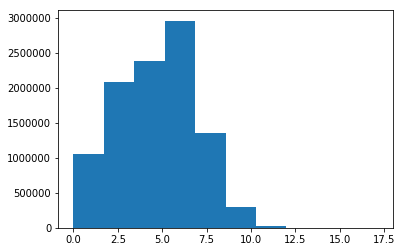

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(np.log1p(prediction.flatten()))